In [13]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from scipy.ndimage import label, sum
from z3 import *
from IPython.display import Markdown, display,IFrame,HTML,Image

### Puzzle as published 
https://www.janestreet.com/puzzles/knight-moves-3-index/

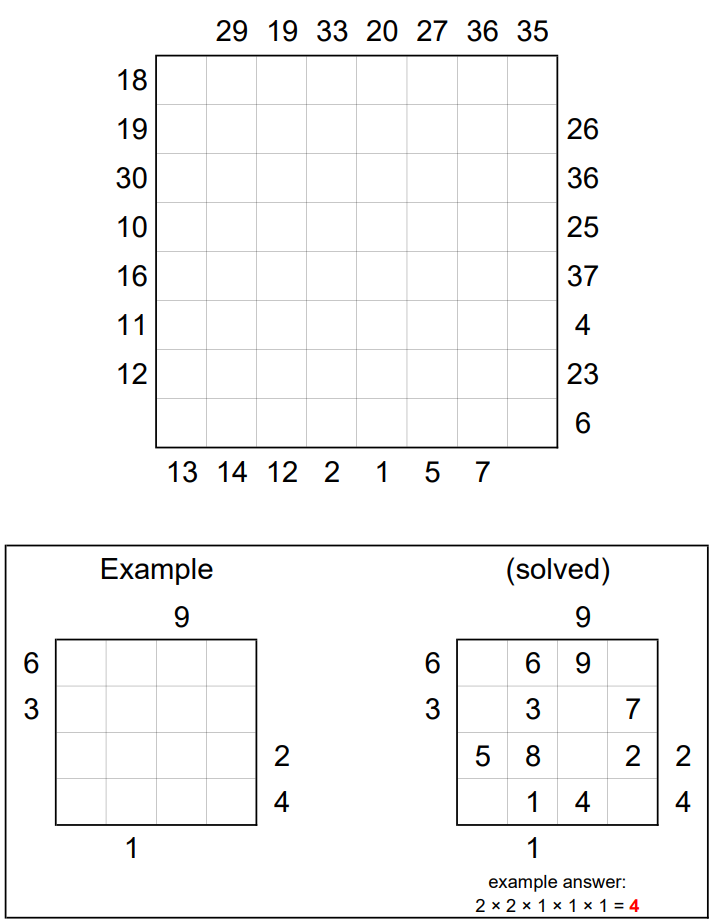

### Knight Moves 3

Place the numbers 1, 2,…,
N
(for some
N
) on a subset of the squares
above, so that it is possible for a knight to move from 1 to
N
via a
series of legal knight’s moves. Each number
inside
the grid represents
the height of a building located at that square, and we can think of
the knight as jumping from rooftop to rooftop on this series of
incrementally taller buildings.
A number
outside
the grid indicates the first (i.e. smallest) number
for which the knight was visible looking into the grid in the
direction of that row or column. (As shown in the example.)
The answer to this puzzle is the
smallest achievable product
of the
areas of the connected groups of empty squares in the completed grid.

In [5]:
url='https://www.janestreet.com/puzzles/knight-moves-3-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Puzzle as published \n'+url))
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Image('https://www.janestreet.com/puzzles/20190805_knight_moves_3.png',width=400))
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[11:26]))))

In [6]:
# Setup the constraints
top = np.array([0,29,19,33,20,27,36,35])
rhs = np.array([0,26,36,25,37,4,23,6])
bot = np.array([13,14,12,2,1,5,7,0])
lhs = np.array([18,19,30,10,16,11,12,0])

In [14]:
# finds the product of empty regions
def areas(grid):
    labels, num = label(grid < 1)
    areas = sum(grid < 1, labels, index=range(1, num + 1))
    return int(np.prod(areas))

# defines how a knight can move
def moves(i, j, N):
    moves = [(2, 1), (1, 2), (-1, 2), (-2, 1), (-2, -1), (-1, -2), (1, -2), (2, -1)]
    return [(i + x, j + y) for x, y in moves if 0 <= i + x < N and 0 <= j + y < N]

<h3>Solved in 9.414136 seconds</h3>

<h3>Product of regions is 144</h3>

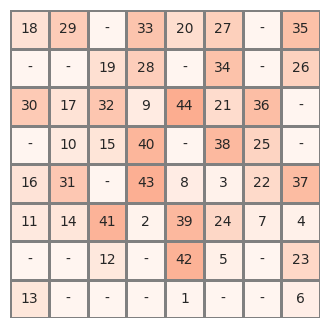

In [19]:
solution, smallest = None, float('inf')
start = time.time()
# this method of looping is needed to guarentee we have the minimum as z3 optimize does not work with our areas function
while True:
    check = solution
    for HIGHEST in range(37,50):
        X = np.array(IntVector("x", 8**2), dtype=object).reshape((8, 8))
        # faster than using just s = Solver() for this problem
        s = Tactic("qffd").solver()

        # every value needs to be greater than 0 but it is unclear how high it can go also one instance of every number
        s += [And(val >= 0, val <= HIGHEST) for pos, val in np.ndenumerate(X)]
        s += [PbEq([(val == n, 1) for (r, c), val in np.ndenumerate(X)], 1) for n in range(1, HIGHEST + 1)]
        # moves in the pattern of a knight
        s += [Or(val == 0, val == 1, PbEq([(X[k][l] == val - 1, 1) for k, l in moves(i, j, 8)], 1)) for (i, j), val in np.ndenumerate(X)]

        # this chunk isn't needed for the code to work, but it makes it run faster
        # the corners are forced
        s += [And(X[0][0] == 18, X[0][7] == 35, X[7][0] == 13, X[7][7] == 6)]
        # values on both a top or bottom and a lhs or rhs are also forced along with respective zeros
        s += [And(X[1][0] == 0, X[1][1] == 0, X[1][2] == 19, X[0][2] == 0)]
        s += [And(X[0][6] == 0, X[1][6] == 0, X[2][6] == 36, X[2][7] == 0)]
        s += [And(X[6][0] == 0, X[6][1] == 0, X[6][2] == 12, X[7][2] == 0)]

        # constraint for value when looking in - don't do for corners since those are forced
        for n in range(1, 7):
            s += If(X[0][n] == 0, If(X[1][n] == 0, If(X[2][n] == 0, If(X[3][n] == 0, If(X[4][n] == 0, If(X[5][n] == 0, 
                    X[6][n] == int(top[n]), X[5][n] == int(top[n])), X[4][n] == int(top[n])), X[3][n] == int(top[n])), 
                    X[2][n] == int(top[n])), X[1][n] == int(top[n])), X[0][n] == int(top[n]))

            s += If(X[n][0] == 0, If(X[n][1] == 0, If(X[n][2] == 0, If(X[n][3] == 0, If(X[n][4] == 0, If(X[n][5] == 0, 
                    X[n][6] == int(lhs[n]), X[n][5] == int(lhs[n])), X[n][4] == int(lhs[n])), X[n][3] == int(lhs[n])), 
                    X[n][2] == int(lhs[n])), X[n][1] == int(lhs[n])), X[n][0] == int(lhs[n]))

            s += If(X[7][n] == 0, If(X[6][n] == 0, If(X[5][n] == 0, If(X[4][n] == 0, If(X[3][n] == 0, If(X[2][n] == 0, 
                    X[1][n] == int(bot[n]), X[2][n] == int(bot[n])), X[3][n] == int(bot[n])), X[4][n] == int(bot[n])), 
                    X[5][n] == int(bot[n])), X[6][n] == int(bot[n])), X[7][n] == int(bot[n]))

            s += If(X[n][7] == 0, If(X[n][6] == 0, If(X[n][5] == 0, If(X[n][4] == 0, If(X[n][3] == 0, If(X[n][2] == 0, 
                    X[n][1] == int(rhs[n]), X[n][2] == int(rhs[n])), X[n][3] == int(rhs[n])), X[n][4] == int(rhs[n])), 
                    X[n][5] == int(rhs[n])), X[n][6] == int(rhs[n])), X[n][7] == int(rhs[n]))
        
        while s.check() == sat:
            m = s.model()
            evalu = np.vectorize(lambda x: m.evaluate(x).as_long())
            r = evalu(X)
            val = areas(r)
            if val >= smallest:
                s += Or([e!=e for (i,j),e in np.ndenumerate(X) ])
            else:
                solution = r
                smallest = val

    if np.array_equal(check, solution):
        break


display(Markdown(f"<h3>Solved in {time.time() - start:.6f} seconds</h3>"))
display(Markdown(f"<h3>Product of regions is {smallest}</h3>"))
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
x = np.array(solution, dtype='int').astype('str')
x[x=="0"] = "-"
x[x=="-1"] = "-"
sns.heatmap(solution, annot=x, cbar=False, cmap="Reds", fmt="", linewidths=1, center=75, linecolor="grey", ax=ax)
ax.axis("off")
plt.show()

### Solution as published
https://www.janestreet.com/puzzles/knight-moves-3-solution/

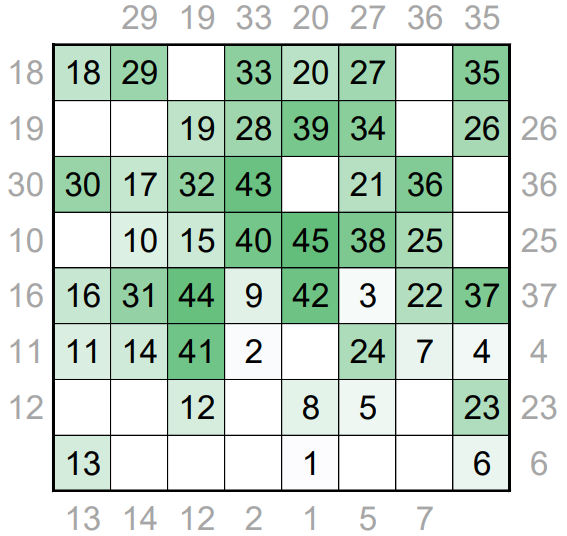

In [20]:
url='https://www.janestreet.com/puzzles/knight-moves-3-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Solution as published\n'+url))
display(Image("https://www.janestreet.com/puzzles/20190831_knight_moves_3_sol.png",width=300))
HTML(str(soup.find_all('div', {'class' :'col-12'})[4]))